# **Predicción de Calidad del Vino (Core)**

**Descripción del Dataset:** 

Este conjunto de datos contiene información sobre distintas características físico-químicas de muestras de vino tinto y su calidad asociada. Las características incluyen acidez fija, acidez volátil, ácido cítrico, azúcar residual, cloruros, dióxido de azufre libre, dióxido de azufre total, densidad, pH, sulfatos y alcohol. La calidad del vino está clasificada en una escala del 0 al 10.

## **1. Carga y Exploración de Datos:**


* **Cargar el dataset y revisar su estructura básica.**

* **Describir las variables y su distribución.**

* **Identificar y tratar valores nulos y outliers.**

In [1]:
# Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, label_binarize

In [31]:
# Cargamos el dataset
path = '../data/WineQT.csv'
df = pd.read_csv(path)

In [32]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [33]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


In [34]:
# Verificamos los valores faltantes
qsna=df.shape[0]-df.isnull().sum(axis=0)
qna=df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)


,datos sin NAs en q,Na en q,Na en %
fixed acidity,1143,0,0.0
volatile acidity,1143,0,0.0
citric acid,1143,0,0.0
residual sugar,1143,0,0.0
chlorides,1143,0,0.0
free sulfur dioxide,1143,0,0.0
total sulfur dioxide,1143,0,0.0
density,1143,0,0.0
pH,1143,0,0.0
sulphates,1143,0,0.0


In [35]:
# Información del dataset, no hay necesidad de convertir los datos. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [ ]:
# Estadísticas descriptivas
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


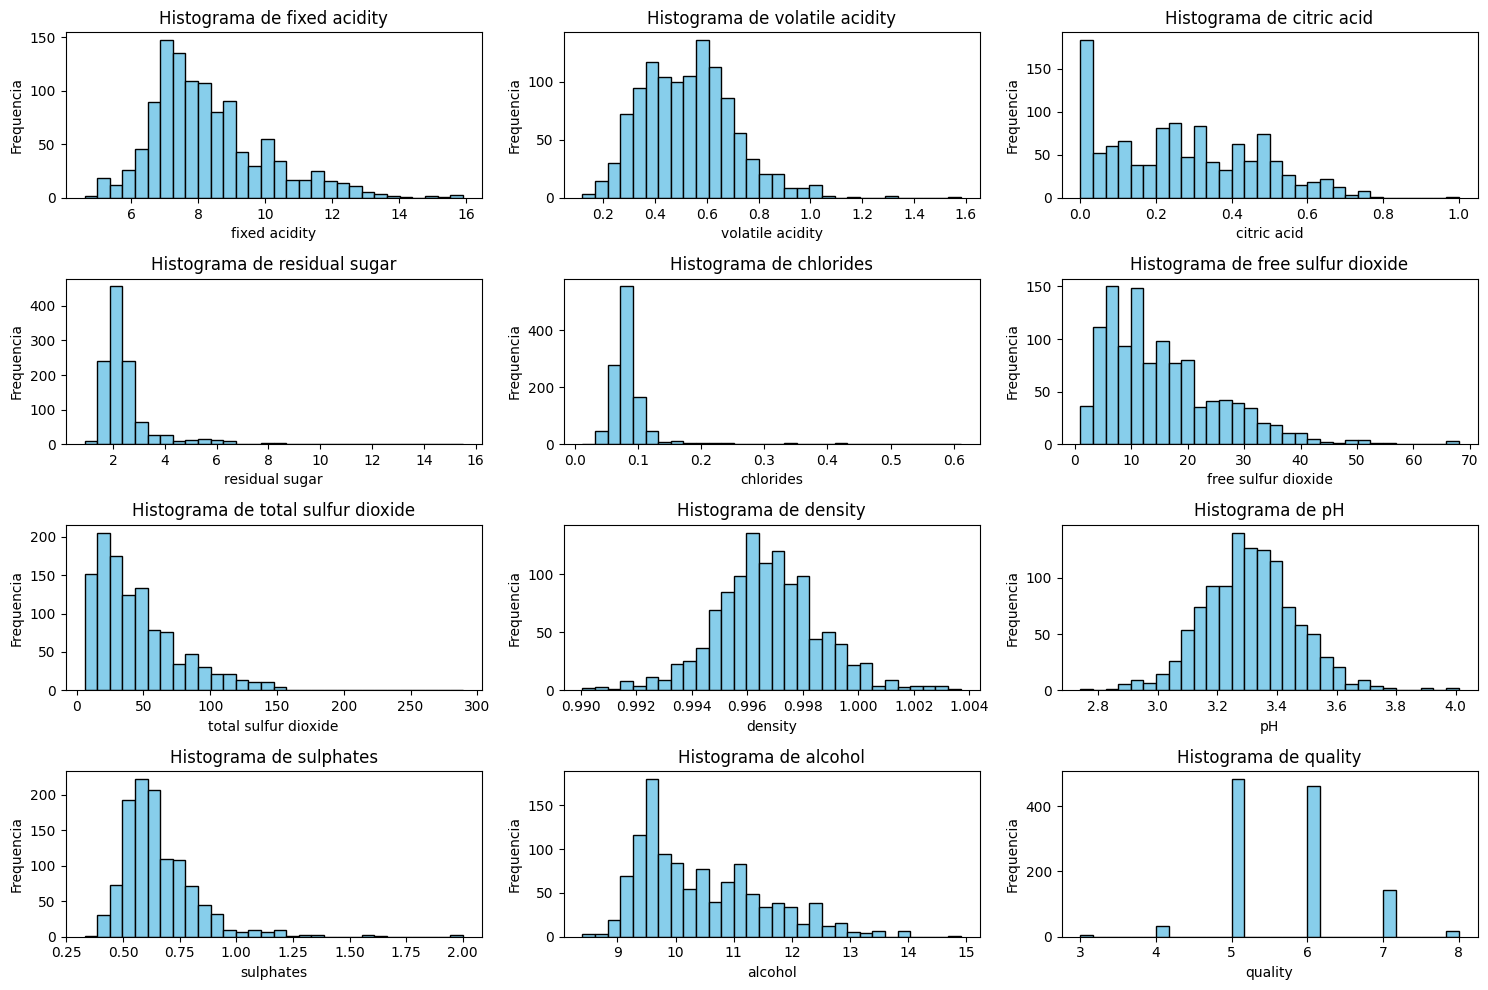

In [37]:
# Verificamos valores atípicos

numeric_columns = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Id']).columns

# Plot histograms for each numeric column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 3, i) 
    plt.hist(df[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequencia')

plt.tight_layout()
plt.show()

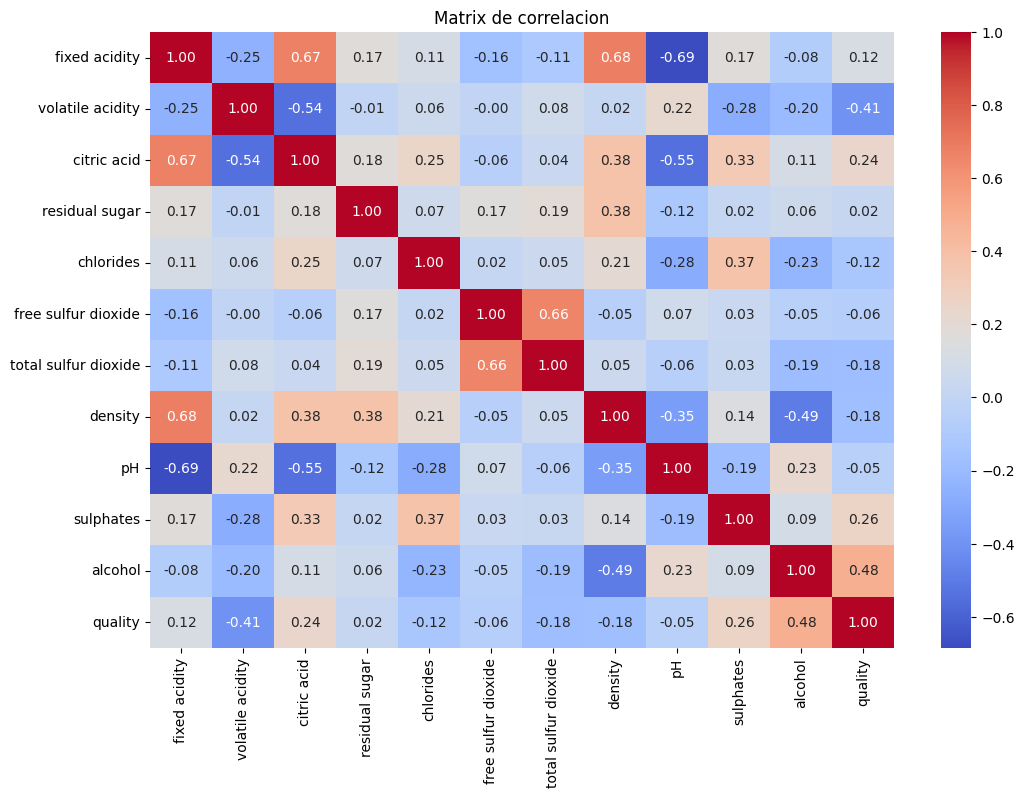

In [55]:
# Matiz de correlación
correlation_matrix = df[numeric_columns].corr()

# Mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Matrix de correlacion')
plt.show()

## **3. Entrenamiento de Modelos de Clasificación:**

* Entrenar al menos tres modelos de clasificación diferentes (por ejemplo, KNN, RandomForest, y Regresión Logística).

* Utilizar validación cruzada para seleccionar los mejores hiperparámetros.

In [ ]:
# Separamos las variables predictoras y la variable objetivo
# Debido a la baja correlación entre las variables predictoras, tomamos todas las posibles caracteristicas para entrenas al modelo
X = df[numeric_columns].drop(columns=['quality'])
y = df['quality']

# Dividimos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Escalamos las variables predictoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **3. Entrenamiento de Modelos de Clasificación:**

In [ ]:
# Modelo KNN con cross-validation y grid search
knn = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': np.arange(1, 20)}  # range of neighbors
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(X_train_scaled, y_train)
best_knn_params = knn_grid_search.best_params_
print("Best KNN Params:", best_knn_params)
print("Best KNN Accuracy (CV):", knn_grid_search.best_score_)

Best KNN Params: {'n_neighbors': np.int64(18)}
Best KNN Accuracy (CV): 0.5689485378009969


In [ ]:
# Modelo Random Forest con cross-validation y grid search
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30]
}
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train_scaled, y_train)
best_rf_params = rf_grid_search.best_params_
print("Best Random Forest Params:", best_rf_params)
print("Best Random Forest Accuracy (CV):", rf_grid_search.best_score_)

Best Random Forest Params: {'max_depth': 20, 'n_estimators': 200}
Best Random Forest Accuracy (CV): 0.6531736023539302


In [ ]:
# Modelo Logistic Regression con cross-validation y grid search
logreg = LogisticRegression(max_iter=1000)
logreg_param_grid = {'C': np.logspace(-3, 3, 7)}  
logreg_grid_search = GridSearchCV(logreg, logreg_param_grid, cv=5, scoring='accuracy')
logreg_grid_search.fit(X_train_scaled, y_train)
best_logreg_params = logreg_grid_search.best_params_
print("Best Logistic Regression Params:", best_logreg_params)
print("Best Logistic Regression Accuracy (CV):", logreg_grid_search.best_score_)

Best Logistic Regression Params: {'C': np.float64(1.0)}
Best Logistic Regression Accuracy (CV): 0.587557797393863


In [56]:
# Evaluamos los modelos
knn_best = KNeighborsClassifier(n_neighbors=best_knn_params['n_neighbors'])
knn_best.fit(X_train_scaled, y_train)
knn_test_accuracy = accuracy_score(y_test, knn_best.predict(X_test_scaled))

rf_best = RandomForestClassifier(n_estimators=best_rf_params['n_estimators'], max_depth=best_rf_params['max_depth'], random_state=42)
rf_best.fit(X_train_scaled, y_train)
rf_test_accuracy = accuracy_score(y_test, rf_best.predict(X_test_scaled))

logreg_best = LogisticRegression(C=best_logreg_params['C'], max_iter=1000)
logreg_best.fit(X_train_scaled, y_train)
logreg_test_accuracy = accuracy_score(y_test, logreg_best.predict(X_test_scaled))


In [57]:
# Imprimimos los resultados

print("\nTest Accuracy:")
print(f"KNN Test Accuracy: {knn_test_accuracy:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")
print(f"Logistic Regression Test Accuracy: {logreg_test_accuracy:.4f}")


Test Accuracy:
KNN Test Accuracy: 0.6070
Random Forest Test Accuracy: 0.7074
Logistic Regression Test Accuracy: 0.6245


 ## **4. Evaluación de Modelos:**

In [ ]:
# Función para graficar la curva ROC

def evaluate_model(model, X_test, y_test, model_name):

    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Imprimimos resultados
    print(f"Evaluation results for {model_name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print("Confusion Matrix:\n", conf_matrix)

    # Plot ROC curve
    plot_roc_curve(model, X_test, y_test, model_name)



c:\Users\damav\Desktop\Codingdojo\clases\MITIC-DataScience_MachineLearning-DanielaRiveros-2024\clases\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Evaluation results for KNN:
Accuracy: 0.61
Precision: 0.57
Recall: 0.61
F1-score: 0.58
Confusion Matrix:
 [[ 0  0  1  0  0  0]
 [ 0  0  4  3  0  0]
 [ 0  0 74 21  2  0]
 [ 0  0 28 57  7  0]
 [ 0  0  1 20  8  0]
 [ 0  0  0  2  1  0]]


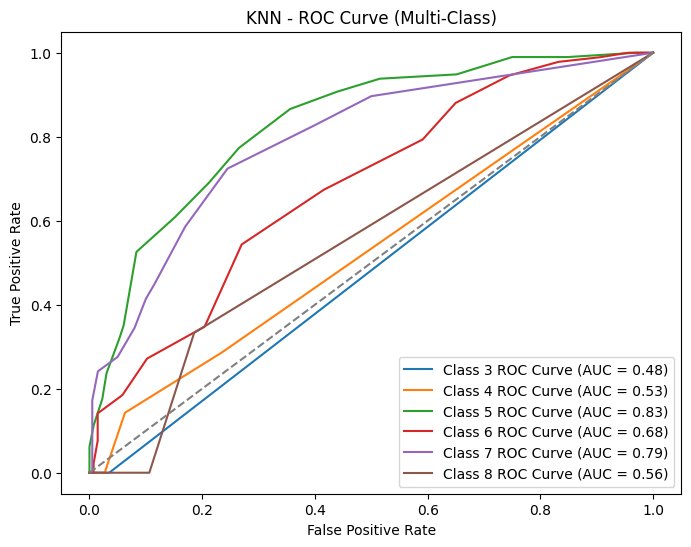

KNN - ROC Curve plotted for all classes
Evaluation results for Random Forest:
Accuracy: 0.71
Precision: 0.67
Recall: 0.71
F1-score: 0.69
Confusion Matrix:
 [[ 0  0  1  0  0  0]
 [ 0  0  4  3  0  0]
 [ 0  0 82 14  1  0]
 [ 0  0 22 66  4  0]
 [ 0  0  3 12 14  0]
 [ 0  0  0  2  1  0]]


c:\Users\damav\Desktop\Codingdojo\clases\MITIC-DataScience_MachineLearning-DanielaRiveros-2024\clases\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


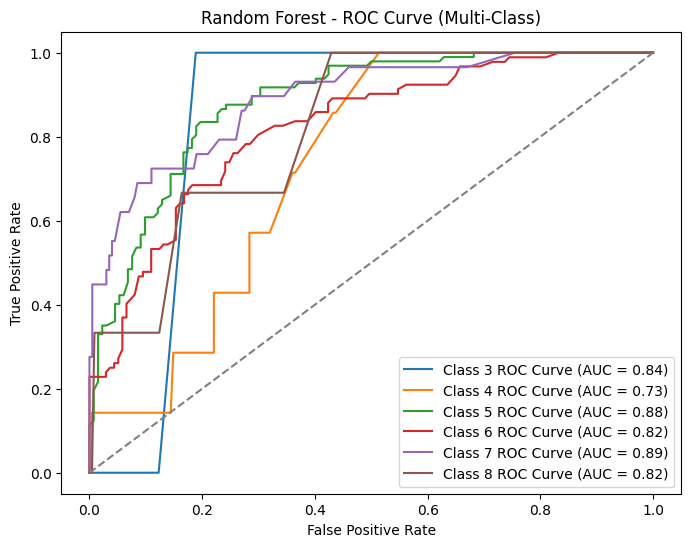

Random Forest - ROC Curve plotted for all classes
Evaluation results for Logistic Regression:
Accuracy: 0.62
Precision: 0.59
Recall: 0.62
F1-score: 0.60
Confusion Matrix:
 [[ 0  0  1  0  0  0]
 [ 0  0  4  3  0  0]
 [ 0  0 76 19  2  0]
 [ 0  0 25 58  8  1]
 [ 0  0  2 18  9  0]
 [ 0  0  0  1  2  0]]


c:\Users\damav\Desktop\Codingdojo\clases\MITIC-DataScience_MachineLearning-DanielaRiveros-2024\clases\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


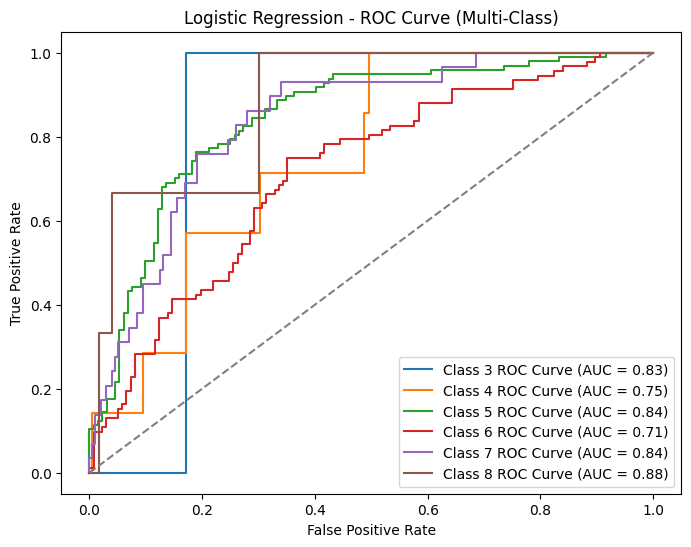

Logistic Regression - ROC Curve plotted for all classes


In [61]:
# Llamamos a la función
evaluate_model(knn_best, X_test_scaled, y_test, "KNN")
evaluate_model(rf_best, X_test_scaled, y_test, "Random Forest")
evaluate_model(logreg_best, X_test_scaled, y_test, "Logistic Regression")

 ## **5. Análisis y Comparación de Resultados:**

* Comparar el rendimiento de los diferentes modelos.

* Discutir cuál modelo ofrece el mejor rendimiento y por qué.

* Identificar las fortalezas y debilidades de cada enfoque en este contexto.

In [62]:
# Creamos una nuevo dataframe
knn_accuracy = 0.61
knn_precision = 0.57
knn_recall = 0.61
knn_f1_score = 0.58

rf_accuracy = 0.71
rf_precision = 0.67
rf_recall = 0.71
rf_f1_score = 0.69

lr_accuracy = 0.62
lr_precision = 0.59
lr_recall = 0.62
lr_f1_score = 0.60

# Create a DataFrame
data = {'Model': ['KNN', 'Random Forest', 'Logistic Regression'],
        'Accuracy': [knn_accuracy, rf_accuracy, lr_accuracy],
        'Precision': [knn_precision, rf_precision, lr_precision],
        'Recall': [knn_recall, rf_recall, lr_recall],
        'F1-Score': [knn_f1_score, rf_f1_score, lr_f1_score]}

df = pd.DataFrame(data)
print(df)

                 Model  Accuracy  Precision  Recall  F1-Score
0                  KNN      0.61       0.57    0.61      0.58
1        Random Forest      0.71       0.67    0.71      0.69
2  Logistic Regression      0.62       0.59    0.62      0.60


El modelo **Random Forest** supera consistentemente a los otros dos en todas las métricas. Tiene mayor exactitud, precisión, recall y puntuación F1. Esto sugiere que Random Forest es mejor para captar los patrones subyacentes en los datos y hacer predicciones precisas.

En este análisis, el costo computacional no es una prioridad. El enfoque está en el rendimiento del modelo según las métricas dadas.

**El modelo con el peor rendimiento:**

Con Menor Exactitud, Precisión, Recall y Puntuación F1: KNN tiene puntuaciones más bajas en estas métricas en comparación con Random Forest y Regresión Logística.

Más Errores de Clasificación: La matriz de confusión de KNN muestra un mayor número de clasificaciones incorrectas, especialmente en algunas clases. Esto indica que KNN es menos preciso al predecir la clase correcta.

Aunque tanto KNN como la Regresión Logística tienen métricas de rendimiento generales similares, el rendimiento de KNN es más inconsistente entre diferentes clases. Random Forest, por otro lado, muestra un rendimiento más equilibrado en todas las clases.

Por lo tanto, según las métricas dadas y las matrices de confusión, KNN es el modelo con el peor rendimiento en este caso.